In [1]:
!gcloud config set project etsy-bigquery-adhoc-prod


If you have a compatible Python interpreter installed, you can use it by setting
the CLOUDSDK_PYTHON environment variable to point to it.

Updated property [core/project].


In [2]:
%load_ext google.cloud.bigquery

In [12]:
import matplotlib.pyplot as plt
import numpy as np
import math

In [4]:
%%bigquery df
select *
from `etsy-sr-etl-prod.yzhang.lsig_v5_web_tight_0305`
where attributions = 1
and alb_price is not null

Query is running:   0%|          |

Downloading:   0%|          |

In [5]:
df.shape

(105377, 12)

In [6]:
df.columns

Index(['requestUUID', 'listing_id', 'attributions', 'client_queries',
       'context_queries', 'query_is_digital', 'listing_is_digital', 'lw_price',
       'lw_promo_price', 'alb_price', 'alb_min_price', 'alb_max_price'],
      dtype='object')

In [52]:
df.lw_price.isna().sum()

0

In [8]:
basic_price_diff = df.alb_price - df.lw_price

In [9]:
basic_price_diff.describe()

count    105377.000000
mean         -0.293045
std           5.718376
min       -1500.000000
25%          -0.280000
50%           0.000000
75%           0.000000
max         583.000000
dtype: float64

In [23]:
np.sum(np.logical_or(basic_price_diff > 5, basic_price_diff < -5))

775

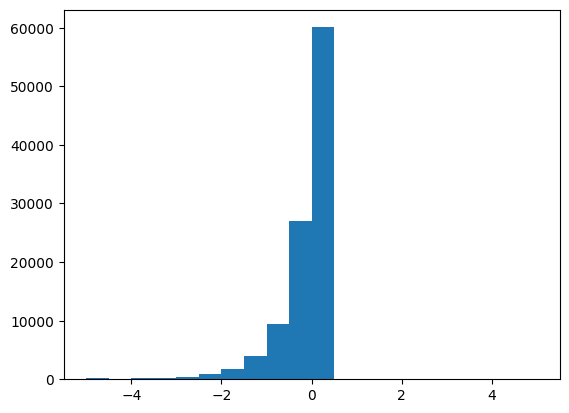

In [24]:
plt.hist(basic_price_diff, bins=20, range=[-5, 5])
plt.show()

Active listing basic price < listing web price

In [26]:
promo_price_diff = df.lw_price - df.lw_promo_price
promo_price_diff = promo_price_diff[~promo_price_diff.isna()]

In [29]:
promo_price_diff.shape

(45767,)

In [30]:
promo_price_diff.describe()

count    45767.000000
mean         7.576014
std         18.269637
min          0.020000
25%          1.455000
50%          3.220000
75%          7.500000
max       1100.000000
dtype: float64

In [40]:
np.sum(np.logical_or(promo_price_diff > 100, promo_price_diff < 0))

237

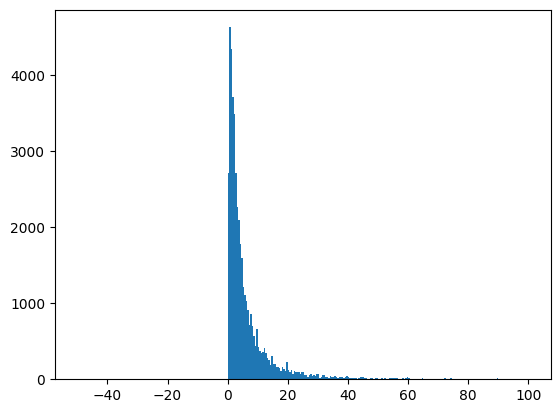

In [41]:
plt.hist(promo_price_diff, bins=300, range=[-50, 100])
plt.show()

In [88]:
real_price_seq = []
alb_real_diff = []
for i in range(df.shape[0]):
    alb_price = df.alb_price[i]
    lw_price = df.lw_price[i]
    promo_price = df.lw_promo_price[i]
    
    base_price = lw_price if lw_price > 0.0 else alb_price
    real_price = base_price if math.isnan(promo_price) else promo_price
    real_price_seq.append(real_price)

    price_diff = real_price - alb_price
    alb_real_diff.append(price_diff)

In [66]:
len(alb_real_diff)

105377

In [67]:
np.sum(np.logical_or(np.array(alb_real_diff) > 25, np.array(alb_real_diff) < -25))

2373

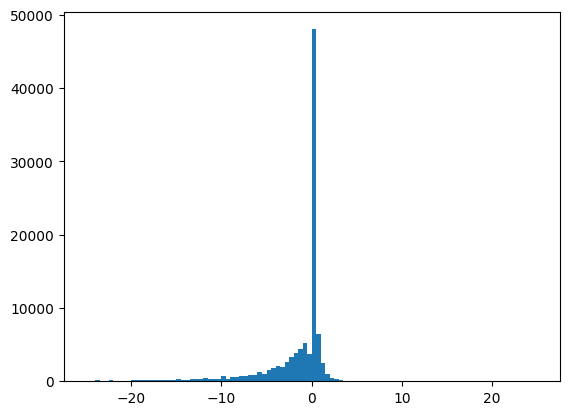

In [68]:
plt.hist(alb_real_diff, bins=100, range=[-25, 25])
plt.show()

In [75]:
print(len(alb_real_diff))
print(np.median(alb_real_diff))
print(np.mean(alb_real_diff))
print(np.quantile(alb_real_diff, 0.25))
print(np.sum(np.array(alb_real_diff) < -5))

105377
0.0
-2.9973450563215875
-2.4000000000000004
15607


In [78]:
discount = df.lw_promo_price / df.lw_price
discount = discount[~discount.isna()]

In [79]:
discount.describe()

count    45767.000000
mean         0.639692
std          0.187879
min          0.246667
25%          0.500000
50%          0.699786
75%          0.799877
max          0.954545
dtype: float64

(array([ 4143.,   854.,  2910.,  8059.,  4089.,  1794.,  4153., 12337.,
         2722.,  4706.]),
 array([0.24666667, 0.31745455, 0.38824242, 0.4590303 , 0.52981818,
        0.60060606, 0.67139394, 0.74218182, 0.8129697 , 0.88375758,
        0.95454545]),
 <BarContainer object of 10 artists>)

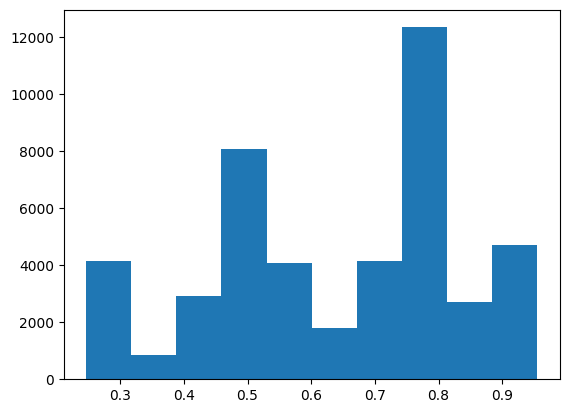

In [80]:
plt.hist(discount)

In [84]:
print(df.lw_price[~df.lw_promo_price.isna()].median())
print(df.lw_price[df.lw_promo_price.isna()].median())

9.99
9.25


In [87]:
df.alb_price.median()

9.49

In [89]:
np.mean(real_price_seq)

16.66550765347277

In [90]:
np.median(real_price_seq)

7.91